In [160]:
from pathlib import Path
import meshio
from mesh_handler import xdmf_to_meshes, meshes_to_xdmf, vtu_to_mesh, mesh_to_vtu,  accessing_mesh_data, create_mock_mesh
from preprocessing_utils import torch_input_edges, torch_input_edges, get_X_y
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

CWD = Path.cwd()
data_path = CWD / "data_cleaned"
xdmf_files = list(data_path.glob("*.pth"))
mesh_ids = [xdmf_file.name.split("_")[1].split(".")[0] for xdmf_file in xdmf_files]

In [161]:
train_ids = mesh_ids[:-20]
test_ids = mesh_ids[-20:]

def sample_rand(train_ids):
    mesh_id = train_ids[np.random.randint(len(train_ids))]
    time_step = np.random.randint(0,79)
    X_nodes, X_edges_undir, y = get_X_y(mesh_id=mesh_id, time_step=time_step)
    return (X_nodes, X_edges_undir, y), mesh_id, time_step

sample_data, sample_mesh_id, sample_ts  = sample_rand(train_ids)
print(sample_mesh_id, sample_ts)
X_nodes, X_edges_undir, y = sample_data

165 35


In [162]:
mesh_id = mesh_ids[0]
X_nodes, X_edges, y = get_X_y(mesh_id, time_step=0)
print(X_nodes.shape)
print(X_edges.shape)
print(y.shape)

torch.Size([11446, 7])
torch.Size([2, 71718])
torch.Size([11446, 4])


In [170]:
mesh_id = mesh_ids[0]
X_nodes_1, X_edges_1, y_1 = get_X_y(mesh_id, time_step=1)

def get_walls(X_nodes):
    velocities = torch.norm(X_nodes[:,3:6], p=2, dim=1)
    border = torch.where(velocities < 1e-10)[0]
    return border

border = get_walls(X_nodes)

In [176]:
import matplotlib.pyplot as plt

diff = X_nodes_1[:,3:] - X_nodes[:, 3:]
border_mask = np.zeros(X_nodes.shape[0])
border_mask[border] = 1

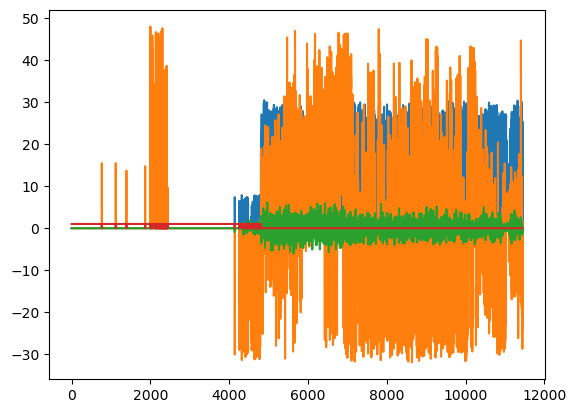

In [177]:
plt.plot(diff[:,:3])
plt.plot(border_mask);

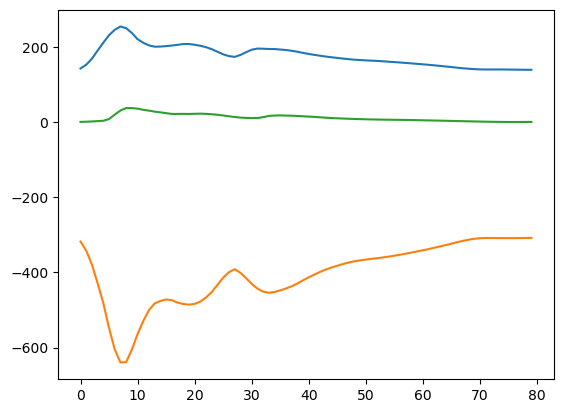

In [142]:
truc = torch.load("data_cleaned/mesh_1.pth")
a = truc["nodes"]
for i in range(3,6):
    plt.plot(a[:,-1,i])

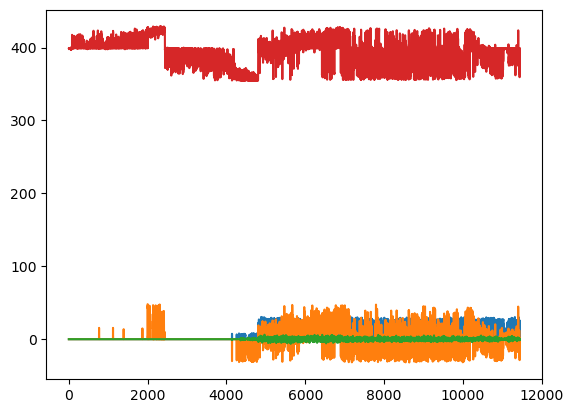

In [114]:
plt.plot(diff)

## model explo

In [53]:
X_edges_dir = torch.cat([X_edges, X_edges[[1, 0], :]], dim=1)

In [54]:
X_edges

tensor([[    0,     0,     0,  ..., 11422, 11430, 11435],
        [    1,    76,   726,  ..., 11425, 11434, 11443]])

In [55]:
from torch_geometric.data import Data

def create_edge_attributes(positions, edge_index):
    i, j = edge_index
    direction = positions[j,:] - positions[i,:]
    distance = torch.norm(direction, dim=1, keepdim=True)
    direction /= distance
    edge_attr = torch.cat([direction, distance], dim=1)
    return edge_attr

edge_attr = create_edge_attributes(X_nodes[:,0:3], X_edges_dir)
data = Data(x=X_nodes, edge_index=X_edges_dir, edge_attr=edge_attr)

In [56]:
from torch_geometric.nn import GraphUNet
import torch.nn.functional as F


in_channels = X_nodes.shape[1]
hidden_channels = 32
out_channels = 16
model = GraphUNet(in_channels, hidden_channels, out_channels, depth=3)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))

In [57]:
model(data.x, data.edge_index)

RuntimeError: Calling addmm on CPU with sparse output requires MKL.

In [145]:
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    
    sample_data, sample_mesh_id, sample_ts  = sample_rand(train_ids)
    X_nodes, X_edges_undir, y = sample_data
    X_edges_dir = torch.cat([X_edges, X_edges[[1, 0], :]], dim=1)
    edge_attr = create_edge_attributes(X_nodes[:,0:3], X_edges_dir)
    data = Data(x=X_nodes, edge_index=X_edges_dir, edge_attr=edge_attr)
    
    output = model(data.x, data.edge_index)
    
    # Compute the loss (example using MSE loss)
    loss = F.mse_loss(output, data.x)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

RuntimeError: Calling addmm on CPU with sparse output requires MKL.

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1000):
    optimizer.zero_grad()
    out = model(node_features, edge_index, edge_attr)

    loss = F.mse_loss(out, y)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 37934.09765625
Epoch 1, Loss: 36062.69140625
Epoch 2, Loss: 34006.6171875
Epoch 3, Loss: 31688.48828125
Epoch 4, Loss: 29154.5546875
Epoch 5, Loss: 26384.498046875
Epoch 6, Loss: 23449.873046875
Epoch 7, Loss: 20414.73046875
Epoch 8, Loss: 17461.56640625
Epoch 9, Loss: 14870.36328125
Epoch 10, Loss: 12950.4052734375
Epoch 11, Loss: 12061.2646484375
Epoch 12, Loss: 12065.03125
Epoch 13, Loss: 12292.5458984375
Epoch 14, Loss: 12069.6083984375
Epoch 15, Loss: 11181.521484375
Epoch 16, Loss: 9823.025390625
Epoch 17, Loss: 8336.51953125
Epoch 18, Loss: 7009.80029296875
Epoch 19, Loss: 5989.47412109375
Epoch 20, Loss: 5290.40869140625
Epoch 21, Loss: 4836.7763671875
Epoch 22, Loss: 4516.962890625
Epoch 23, Loss: 4234.220703125
Epoch 24, Loss: 3936.4619140625
Epoch 25, Loss: 3615.389892578125
Epoch 26, Loss: 3290.161865234375
Epoch 27, Loss: 2998.230712890625
Epoch 28, Loss: 2784.5595703125
Epoch 29, Loss: 2682.091552734375
Epoch 30, Loss: 2686.587890625
Epoch 31, Loss: 2747.98

In [38]:
mesh_id = mesh_ids[58]
X_nodes, X_edges, y = get_X_y(mesh_id, time_step=0)
node_features = X_nodes
edge_index = X_edges
edge_attr = create_edge_attributes(node_features[:,0:3], edge_index)

In [39]:
out = model(node_features, edge_index, edge_attr)
loss = F.mse_loss(out, y)
print(loss.item())

969.9053955078125
